In [47]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import yaml
from glob import glob
import pathlib

FONT_SIZE = 15
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title
matplotlib.rc('lines', linewidth=3)

In [48]:
log_dir = '/data/zhenyus/webcachesim/log'

In [121]:
def to_label(x):
    """
    what to put on legend
    """
    return yaml.dump(
        {k: x[k] for k in x.to_dict() if k not in {
            'cache_size', 
            'byte_hit_rate', 
            'object_hit_rate',
            'trace_file', 
            'n_warmup', 
            'n_early_stop',
            'task_id',
            'elapse',
            'uni_size',
        } and not pd.isnull(x[k])
        })

def to_id(x):
    """
    unique identifier
    """
    return str(yaml.dump(
        {k: x[k] for k in x if k not in {
            'byte_hit_rate', 
            'object_hit_rate',
            'task_id',
            'elapse',
        } and not pd.isnull(x[k])
        }))

    
def load_reports(log_dir):
    timestamps = glob(f'{log_dir}/*.res')
    timestamps = [pathlib.PurePosixPath(t).stem for t in timestamps]
    timestamps.sort()
    tasks = {}
    for t in timestamps:
        with open(f'{log_dir}/{t}.res') as f:
            res = yaml.load(f)
        res = {**res['res'], **res['task']}
        tasks[to_id(res)] = res
    tasks = [{'task_id': k, **v} for k, v in tasks.items()]
    df = pd.DataFrame(tasks)
#     df['task_id'] = df.apply(lambda x: to_id(x), axis='columns')
#     df = df.drop_duplicates(keep='last', subset=[
#         'task_id',
#     ])
    return df

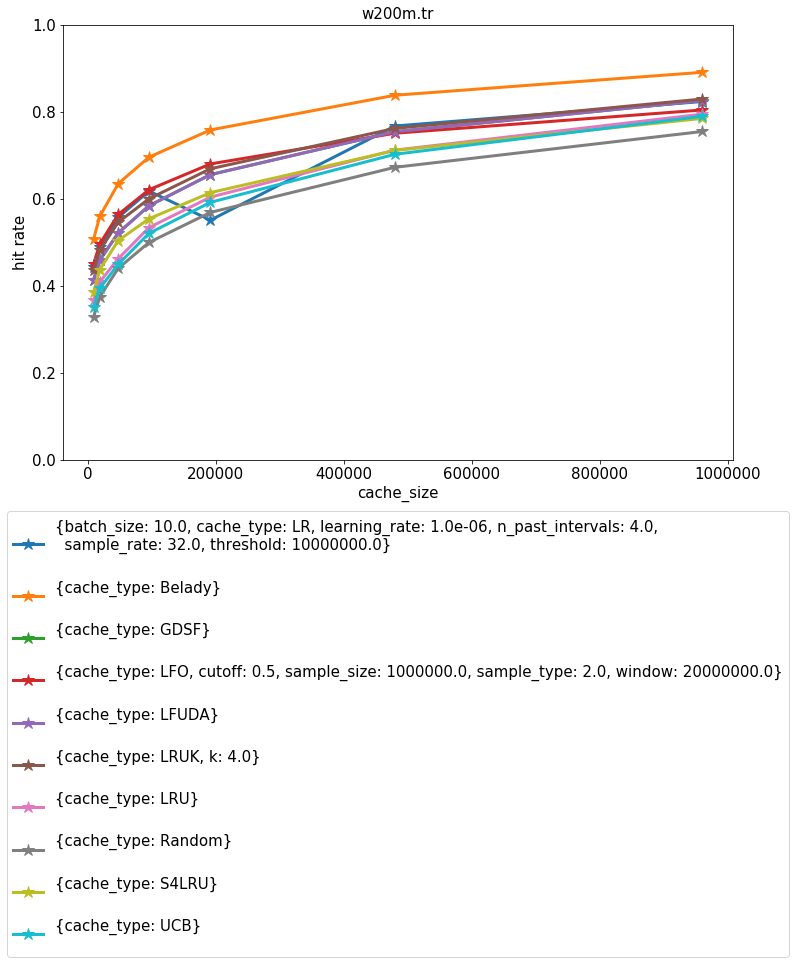

In [126]:
trace = 'w200m.tr'

df = load_reports(log_dir)
filter_idx = (
    (df.trace_file == trace) 
    & (df.uni_size == 1)
    & ((df.cache_type != "LFO") | (df.sample_size == 1000000))
    & (df.n_warmup == 20000000)
#     & (df.n_warmup == 100000)
#     & (df.if_uni_size == False)
#     & (df.cache_capacity <= 30000)
#     & (
#         (df.algorithm.isin(['SLRU', 'Belady', 'Random', 'LRU', 'BeladyLR'])) 
#         | (df.algorithm.isin(['FIFOLR', 'LRULR', 'GDSFLR', 'LFULR']))
#         | ((df.algorithm == 'LR') & (df.sample_rate == 32))
#         | ((df.algorithm == 'SLRULR') & (df.sample_rate == 32))
#     )
)

df1 = df[filter_idx].copy()
df1['label'] = df1.apply(lambda x: to_label(x), axis='columns')
fig, ax = plt.subplots(figsize=(12, 8))
for k, grp in df1.groupby(['label']):
    grp = grp.sort_values(by=['cache_size'])
    ax = grp.plot(ax=ax, kind='line', x='cache_size', y='byte_hit_rate', label=k, marker='*', markersize=12)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1))
plt.ylabel('hit rate')
plt.title(trace)
plt.ylim([0, 1.])
plt.show()

In [127]:
df1[['byte_hit_rate', 'cache_size', 'cache_type']].pivot(index='cache_type', columns='cache_size', values='byte_hit_rate')

cache_size,9600,19200,48000,96000,192000,480000,960000
cache_type,,,,,,,
Belady,0.507238,0.559491,0.634563,0.695575,0.758187,0.837926,0.890709
GDSF,0.413774,0.458722,0.521308,0.583731,0.655460,0.754018,0.825571
LFO,0.450408,0.495917,0.563851,0.620665,0.680048,0.750547,0.804093
LFUDA,0.413774,0.458722,0.521308,0.583731,0.655460,0.754018,0.825571
LR,0.442075,0.487831,0.557230,0.617531,0.550803,0.767211,0.823549
LRU,0.366307,0.408642,0.461979,0.533608,0.603711,0.711789,0.794448
LRUK,0.435752,0.481427,0.546003,0.599830,0.668941,0.761714,0.829320
Random,0.328672,0.374453,0.440062,0.499504,0.568570,0.672224,0.754603
S4LRU,0.385418,0.436898,0.503887,0.553884,0.614027,0.710973,0.784698


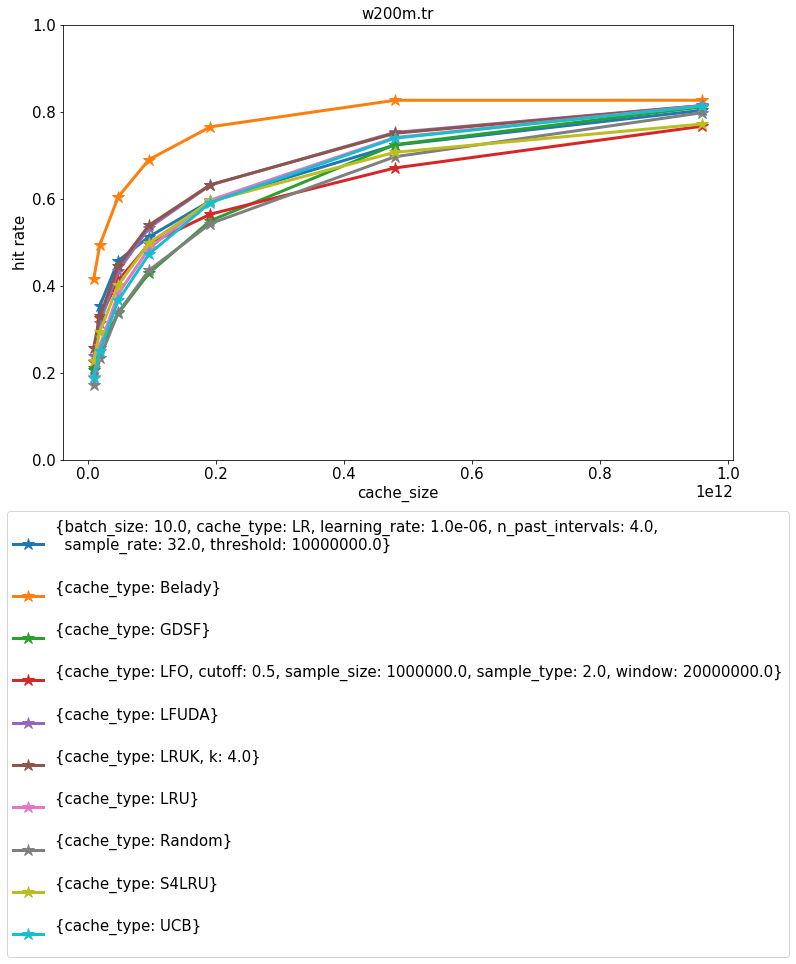

In [131]:
trace = 'w200m.tr'

df = load_reports(log_dir)
filter_idx = (
    (df.trace_file == trace) 
    & (df.uni_size == 0)
    & ((df.cache_type != "LFO") | (df.sample_size == 1000000))
    & (df.n_warmup == 20000000)
#     & (df.n_warmup == 100000)
#     & (df.if_uni_size == False)
#     & (df.cache_capacity <= 30000)
#     & (
#         (df.algorithm.isin(['SLRU', 'Belady', 'Random', 'LRU', 'BeladyLR'])) 
#         | (df.algorithm.isin(['FIFOLR', 'LRULR', 'GDSFLR', 'LFULR']))
#         | ((df.algorithm == 'LR') & (df.sample_rate == 32))
#         | ((df.algorithm == 'SLRULR') & (df.sample_rate == 32))
#     )
)

df1 = df[filter_idx].copy()
df1['label'] = df1.apply(lambda x: to_label(x), axis='columns')
fig, ax = plt.subplots(figsize=(12, 8))
for k, grp in df1.groupby(['label']):
    grp = grp.sort_values(by=['cache_size'])
    ax = grp.plot(ax=ax, kind='line', x='cache_size', y='byte_hit_rate', label=k, marker='*', markersize=12)
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1))
plt.ylabel('hit rate')
plt.title(trace)
plt.ylim([0, 1.])
plt.show()

In [132]:
df1[['byte_hit_rate', 'cache_size', 'cache_type']].pivot(index='cache_type', columns='cache_size', values='byte_hit_rate')

cache_size,9600000000,19200000000,48000000000,96000000000,192000000000,480000000000,960000000000
cache_type,,,,,,,
Belady,0.414768,0.493362,0.604367,0.689930,0.765384,0.826356,0.826356
GDSF,0.209949,0.257285,0.336574,0.428880,0.549486,0.724464,0.811063
LFO,0.225032,0.326637,0.411997,0.496126,0.564566,0.670732,0.766721
LFUDA,0.237470,0.313961,0.434256,0.533034,0.631532,0.752381,0.814397
LR,0.205830,0.353430,0.457460,0.512496,0.595173,0.723341,0.803306
LRU,0.190943,0.261215,0.381147,0.485759,0.596894,0.740758,0.813637
LRUK,0.257455,0.330342,0.444639,0.539043,0.632331,0.750577,0.813929
Random,0.171539,0.232671,0.338630,0.435378,0.542856,0.696569,0.797825
S4LRU,0.226486,0.294355,0.401959,0.497943,0.594091,0.706768,0.771857
